## Semantic Search with Dense Vector Embeddings

In [1]:
import sys
import os
sys.path.append("..")
import pickle

import numpy
import pandas
from aips import *
from aips.spark import create_view_from_collection
from pyspark.conf import SparkConf

pandas.set_option("display.max_rows", 1000)
engine = get_engine()
conf = SparkConf()
conf.set("spark.driver.memory", "8g")
conf.set("spark.executor.memory", "8g")
conf.set("spark.dynamicAllocation.enabled", "true")
conf.set("spark.dynamicAllocation.executorMemoryOverhead", "8g")
spark = SparkSession.builder.appName("AIPS").config(conf=conf).getOrCreate()

## Load and clean the Outdoors dataset

## Transformer time!

In [3]:
from sentence_transformers import SentenceTransformer, util as STutil
transformer = SentenceTransformer("roberta-base-nli-stsb-mean-tokens")

## Listing 13.16

In [4]:
def get_embeddings(texts, cache_name, ignore_cache=False):
    cache_file_name = f"data/embeddings/{cache_name}.pickle"
    if ignore_cache or not os.path.isfile(cache_file_name):
        embeddings = transformer.encode(texts)
        os.makedirs(os.path.dirname(cache_file_name), exist_ok=True)
        with open(cache_file_name, "wb") as fd:
            pickle.dump(embeddings, fd)
    else:
        with open(cache_file_name, "rb") as fd:
            embeddings = pickle.load(fd)
    return embeddings

In [2]:
from aips.data_transformers.outdoors import load_dataframe

transformer = SentenceTransformer("roberta-base-nli-stsb-mean-tokens")
cache_name = "outdoors_semantic_search_embeddings"

outdoors_dataframe = load_dataframe("data/outdoors/posts.csv")
titles = outdoors_dataframe.rdd.map(lambda x: x.title).collect()
titles = list(filter(None, titles))
embeddings = get_embeddings(titles, cache_name)

print(f"Number of embeddings: {len(embeddings)}")
print(f"Dimensions per embedding: {len(embeddings[0])}")

NameError: name 'SentenceTransformer' is not defined

### Explore the top similarities for the titles

In [ ]:
#Find the pairs with the highest cosine similarity scores
similarities = STutil.pytorch_cos_sim(embeddings[0:100], embeddings[0:100])

a_phrases = []
b_phrases = []
scores = []
for a in range(len(similarities) - 1):
    for b in range(a + 1, len(similarities)):
        a_phrases.append(titles[a])
        b_phrases.append(titles[b])
        scores.append(float(similarities[a][b]))
        
comparisons = pandas.DataFrame({"phrase a": a_phrases, "phrase b": b_phrases,
                                "score": scores, "name": "similarity"})
comparisons = comparisons.sort_values(by=["score"], ascending=False, ignore_index=True)
comparisons["idx"] = range(len(comparisons))
comparisons[comparisons["score"] > 0.5]

,phrase a,phrase b,score,name,idx
0,How do I recognize if someone is suffering fro...,How should I treat hypothermia?,0.846395,similarity,0
1,How should I treat poison ivy?,What can I do to prevent getting poison ivy?,0.811995,similarity,1
2,What is the difference between the different t...,What is the difference between camber and rock...,0.800817,similarity,2
3,How do I tie a sleeping bag to my backpack?,What is the best way to store my sleeping bag ...,0.794242,similarity,3
4,What should I look for if I want to buy a wint...,What is the best way to store my tent?,0.790016,similarity,4
5,How do I set a top rope anchor?,How do I inspect a climbing rope?,0.753913,similarity,5
6,What is the safest way to purify water?,What are the different methods to purify water?,0.745218,similarity,6
7,"What do I need to look for in good, quality hi...",What is the difference between men's and women...,0.710361,similarity,7
8,"What to look for in a durable, 3-season sleepi...",What is the best way to store my sleeping bag ...,0.704152,similarity,8
9,How should I check that the anchor is secure w...,How do I set a top rope anchor?,0.698881,similarity,9


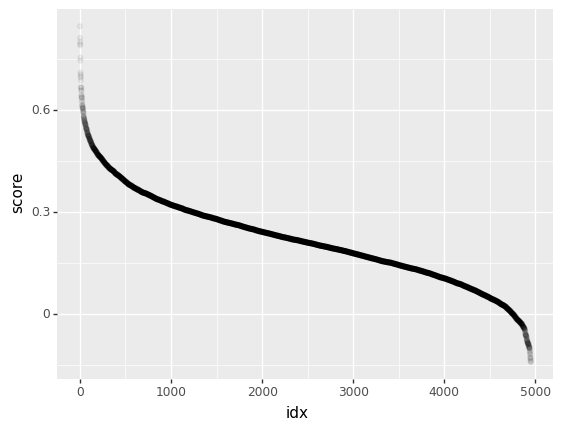

{<ggplot: (8782824508401)>}

In [ ]:
from plotnine import *
{ggplot(comparisons, aes("idx", "score")) + geom_point(alpha=.05)}

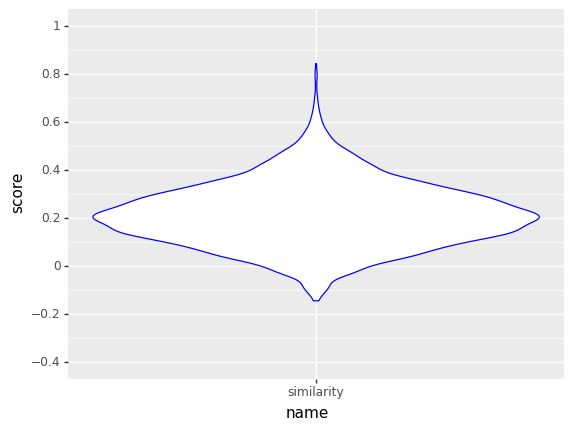

{<ggplot: (8782835869672)>}

In [ ]:
from plotnine import *
{
    ggplot(comparisons, aes("name", "score")) +
    geom_violin(color="blue") + 
    scale_y_continuous(limits=[-0.4, 1.0], breaks=[-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0])
}

## Listing 13.17


### Quickly matching vectors at query time

Now that we can get and compare concept embeddings, we need to be able to search these embeddings efficiently.

In [13]:
def normalize_embedding(embedding):
    normalized = numpy.divide(embedding, numpy.linalg.norm(embedding))
    return list(map(float, normalized))

In [10]:
import nmslib
# initialize a new index, using a HNSW index on Dot Product
titles_index = nmslib.init(method="hnsw", space="negdotprod")
normalized_embeddings = list(map(normalize_embedding, embeddings))
titles_index.addDataPointBatch(normalized_embeddings)
titles_index.createIndex(print_progress=True)

NameError: name 'embeddings' is not defined

In [ ]:
"""
query_vector = stsb.encode("mountain bike").tolist()
cos_sims = STutil.pytorch_cos_sim(title_embeddings, query_vector)


norm_query_vector = list(map(float, numpy.divide(query_vector,
                            numpy.linalg.norm(query_vector))))
dot_sims = STutil.dot_score(normalized_embeddings, norm_query_vector)

test = numpy.divide(dot_sims, numpy.multiply(numpy.linalg.norm(query_vector),
                                             numpy.linalg.norm(title_embeddings)))
print(cos_sims[0:4])
print(query_vector)
print(dot_sims[0:4])
print(norm_query_vector)
print(test[0:4])
"""

'\nquery_vector = stsb.encode("mountain bike").tolist()\ncos_sims = STutil.pytorch_cos_sim(title_embeddings, query_vector)\n\n\nnorm_query_vector = list(map(float, numpy.divide(query_vector,\n                            numpy.linalg.norm(query_vector))))\ndot_sims = STutil.dot_score(normalized_embeddings, norm_query_vector)\n\ntest = numpy.divide(dot_sims, numpy.multiply(numpy.linalg.norm(query_vector),\n                                             numpy.linalg.norm(title_embeddings)))\nprint(cos_sims[0:4])\nprint(query_vector)\nprint(dot_sims[0:4])\nprint(norm_query_vector)\nprint(test[0:4])\n'

## Listing 13.18

In [11]:
#dedup these two functions from 13.3
def print_labels(prefix,matches):
    display(HTML(f"<h4>Results for: <em>{prefix}</em></h4>"))
    for l, d in matches:
        print(str(int(d * 1000) / 1000), "|", l)
        
def embedding_search(index, query, phrases, k=20, min_similarity=0.75):
    matches = []
    query_embedding = transformer.encode(query, convert_to_tensor=True)
    query_embedding = normalize_embedding(query_embedding)
    ids, distances = index.knnQuery(query_embedding, k=k)
    for i in range(len(ids)):
        distance = 1.0 - distances[i]
        if distance > min_similarity:
            matches.append((phrases[ids[i]], distance))
    if not len(matches):
        matches.append((phrases[ids[1]], 1.0 - distances[1]))
    return matches

def semantic_search(query, phrases):
    results = embedding_search(titles_index, query, phrases,
                               k=5, min_similarity=0.6)   
    print_labels(query, results)  

In [12]:
semantic_search("mountain hike", titles)

ValueError: Must call createIndex or loadIndex before this method

## Listing 13.19
Perform vector search utilizing our configured search engine

In [14]:
cache_name = "all_outdoors_title_embeddings"

def index_outdoor_title_embeddings():
    create_view_from_collection(engine.get_collection("outdoors"),
                                "outdoors")
    outdoors_dataframe = spark.sql("""SELECT id, title FROM outdoors
                                      WHERE title IS NOT NULL""")
    print(f"Calculating Embeddings for {outdoors_dataframe.count()} movies.")
    ids = outdoors_dataframe.rdd.map(lambda x: x.id).collect()
    titles = outdoors_dataframe.rdd.map(lambda x: x.title).collect()
    embeddings = list(map(normalize_embedding,
                          get_embeddings(titles, cache_name)))
    embeddings_dataframe = spark.createDataFrame(zip(ids, titles, embeddings),
                                   schema=["id", "title", "title_embeddings"])
    
    collection = engine.create_collection("outdoors_with_embeddings")
    print(f"Writing {embeddings_dataframe.count()} movies to 'outdoors_with_embeddings'")
    collection.write(embeddings_dataframe)
    return collection
        
def semantic_search_with_engine(collection, query):
    query_vector = normalize_embedding(transformer.encode(query))
    request = {"query_vector": query_vector,
               "query_field": "title_embeddings",
               "quantization_size": "FLOAT32"}
    documents = collection.vector_search(**request)
    print_labels(query, [(d["title"], d["score"])
                         for d in documents])

In [15]:
embeddings_collection = index_outdoor_title_embeddings()

Calculating Embeddings for 5331 movies.
Wiping "outdoors_with_embeddings" collection
Creating "outdoors_with_embeddings" collection
Status: Success
Writing 5331 movies to 'outdoors_with_embeddings'


In [18]:
semantic_search_with_engine(embeddings_collection, "mountain hike")

0.861 | How is elevation gain and change measured for hiking trails?
0.857 | How do I Plan a Hiking Trip to Rocky Mountain National Park, CO
0.849 | Hints for hiking the west highland way
0.847 | New Hampshire A.T. Section Hike in May? Logistics and Trail Conditions
0.839 | Long distance hiking trail markings in North America or parts thereof


## Visualize the titles in 3d vector space

In [17]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
vectors = embeddings.numpy()
pca = PCA(n_components=3)
pca_data = pca.fit_transform(vectors)

label_ids = []
label_texts = []
ids,_ = titles_index.knnQuery(embeddings[100], k=2)
label_ids += [idx for idx in ids]
ids,_ = titles_index.knnQuery(embeddings[505], k=2)
label_ids += [idx for idx in ids]
label_texts += [titles[idx].lower() for idx in label_ids]
markers = ["v"]*len(vectors)

components = pandas.DataFrame({
    "x": pca_data[:,0],
    "y": pca_data[:,1],
    "z": pca_data[:,2]
})

ax = plt.figure(figsize=(24,16)).gca(projection="3d")
ax.scatter(
    components["x"].values, 
    components["y"].values, 
    c=components["y"].values, 
    marker="v", 
    alpha=0.3
)

for i,label in zip(label_ids,label_texts):
    x = components["x"][i]
    y = components["y"][i]
    z = components["z"][i]
    zdir = "y"
    ax.text(x, y, z, label, zdir)

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-10, 10)
ax.set_xlabel("PCA X Label")
ax.set_ylabel("PCA Y Label")
ax.set_zlabel("PCA Z Label")
plt.show()

NameError: name 'embeddings' is not defined

Up next: [Chapter 14: Question Answering with a Fine-tuned Large Language Model](../ch14/1.question-answering-visualizer.ipynb)